# Age prediction


In [1]:
%load_ext autoreload
%autoreload 2

In [69]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import umap
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot
from utilities import montecarlo_crossvalidation
from utilities import model_optimization
from utilities import gridsearch_bias
from utilities import variable_importance_df

In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [5]:
tsetse_data_copy = tsetse_data.copy()

In [6]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data_copy[dList]

In [7]:
tsetse_females_thorax = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'f') & (descriptorsDF['Tissue'] == 'Thorax')]

tsetse_females_head = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'f') & (descriptorsDF['Tissue'] == 'Head')]

In [8]:
tsetse_females_thorax.groupby("Age")["ID"].count()

Age
3d    136
5w     96
7w    122
Name: ID, dtype: int64

In [9]:
tsetse_females_head.groupby("Age")["ID"].count()

Age
3d    133
5w     92
7w    120
Name: ID, dtype: int64

In [10]:
tsetse_females_thorax_copy = tsetse_females_thorax.copy()
tsetse_females_head_copy = tsetse_females_head.copy()

In [11]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF_thorax = tsetse_females_thorax[dList]
tsetse_females_thorax_copy.drop(dList, axis=1,inplace=True)


descriptorsDF_head = tsetse_females_head_copy[dList]
tsetse_females_head_copy.drop(dList, axis=1,inplace=True)

In [12]:
waveNumslist = tsetse_females_thorax_copy.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [13]:
y_labels_head = descriptorsDF_head['Age']
y_labels_thorax = descriptorsDF_thorax['Age']

## Age prediction females

In [72]:
X_thorax = tsetse_females_thorax.loc[:,"1800":"602"]
y_thorax = tsetse_females_thorax.loc[:,"Age"]

X_head = tsetse_females_head.loc[:,"1800":"602"]
y_head = tsetse_females_head.loc[:,"Age"]

In [73]:
waveNumslist_reduced = X_thorax.columns.values.tolist()
wavenumbers_reduced = [int(x) for x in waveNumslist_reduced]

In [74]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [17]:
shape_data = {"train_head": X_hd_train.shape,
              "train_thorax": X_th_train.shape,
              "test_head": X_hd_test.shape,
              "tsetse_thorax":X_th_test.shape}
shape_data_df = pd.DataFrame(shape_data,index=['samples','features'])
shape_data_df
shape_data_df.to_excel("../results/tables/informative_region_results/train_test_shape_age_females.xlsx")


In [18]:
shape_data_classes = {"train_head": y_hd_train.value_counts(),
              "train_thorax": y_th_train.value_counts(),
              "test_head": y_hd_test.value_counts(),
              "tsetse_thorax":y_th_test.value_counts()}

shape_data_classes_df = pd.DataFrame(shape_data_classes)
shape_data_classes_df
shape_data_classes_df.to_excel("../results/tables/informative_region_results/train_test_shape_age_classes_females.xlsx")

In [75]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [76]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

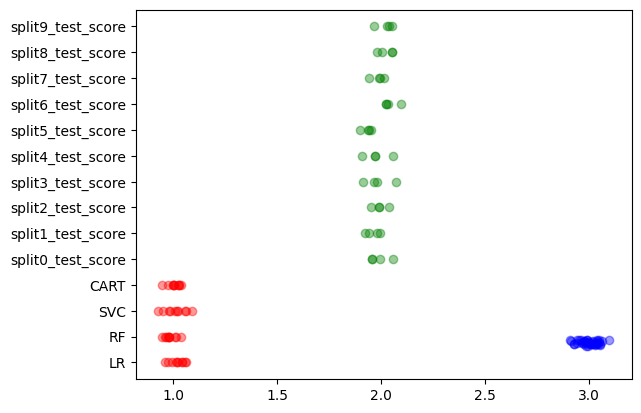

In [64]:
sn.boxplot(data=data_plot_head, x='param_clf',y='value', ax=ax)
palette = ['r', 'g', 'b', 'y']
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.4, color=c)
plt.show()

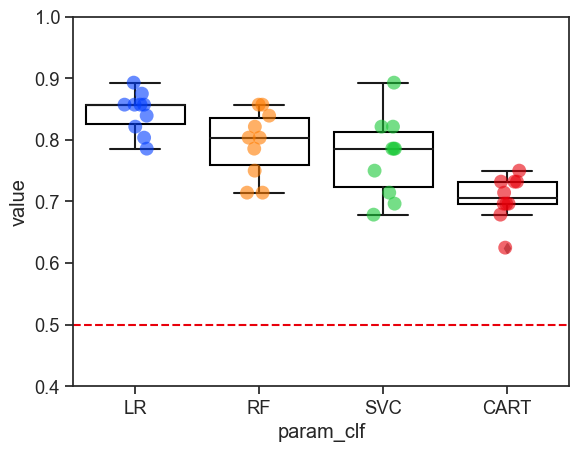

In [52]:
fig, ax = plt.subplots()
sn.boxplot(data=data_plot_head, x='param_clf', y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value', ax=ax,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax.lines, color='k')
ax.axhline(0.5, color='r',ls='--')
ax.set_ylim(0.4,1)


for i,box in enumerate(ax.patches):
    box.set_edgecolor('black')


In [77]:
output = data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.701786  0.044583
1        LR  0.839286  0.053240
2        RF  0.785714  0.058926
3       SVC  0.778571  0.056595


In [78]:
output = data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.685965  0.049931
1        LR  0.845614  0.042008
2        RF  0.729825  0.068797
3       SVC  0.728070  0.058039


In [79]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)

Best model parameters{'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [80]:
# thorax
best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [81]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [82]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.8405797101449275
Accuracy on test set: 0.9014084507042254


In [83]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
3d,0.766667,0.958333,0.851852,24.00000
5w,0.875000,0.736842,0.800000,19.00000
7w,0.913043,0.807692,0.857143,26.00000
accuracy,0.840580,0.840580,0.840580,0.84058
macro avg,0.851570,0.834289,0.836332,69.00000
weighted avg,0.851654,0.840580,0.839568,69.00000


In [28]:
report_head.to_excel("../results/tables/informative_region_results/accuracy_age_females_head.xlsx")

In [84]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
3d,0.954545,0.954545,0.954545,22.000000
5w,0.880000,0.880000,0.880000,25.000000
7w,0.875000,0.875000,0.875000,24.000000
accuracy,0.901408,0.901408,0.901408,0.901408
macro avg,0.903182,0.903182,0.903182,71.000000
weighted avg,0.901408,0.901408,0.901408,71.000000


In [30]:
report_thorax.to_excel("../results/tables/informative_region_results/accuracy_age_females_thorax.xlsx")

In [61]:
# roc curve for multiclass

label_binarizer = LabelBinarizer().fit(y_hd_train)
y_onehot_hd_test = label_binarizer.transform(y_hd_test)

In [62]:
label_binarizer_thorax = LabelBinarizer().fit(y_th_train)
y_onehot_th_test = label_binarizer_thorax.transform(y_th_test)

In [63]:
print(y_onehot_hd_test.shape)
print(y_hd_test.shape)

(69, 3)
(69,)


In [34]:
class_of_interest = "3d"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

0

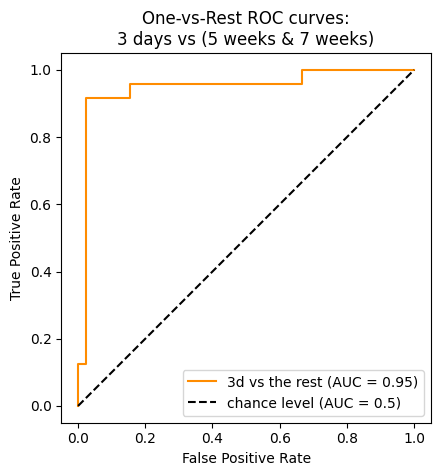

In [35]:
RocCurveDisplay.from_predictions(
    y_onehot_hd_test[:, class_id],
    y_head_prob[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n3 days vs (5 weeks & 7 weeks)")
plt.legend()
plt.show()

In [36]:
n_classes=3
target_names = ['3d','5w','7w']


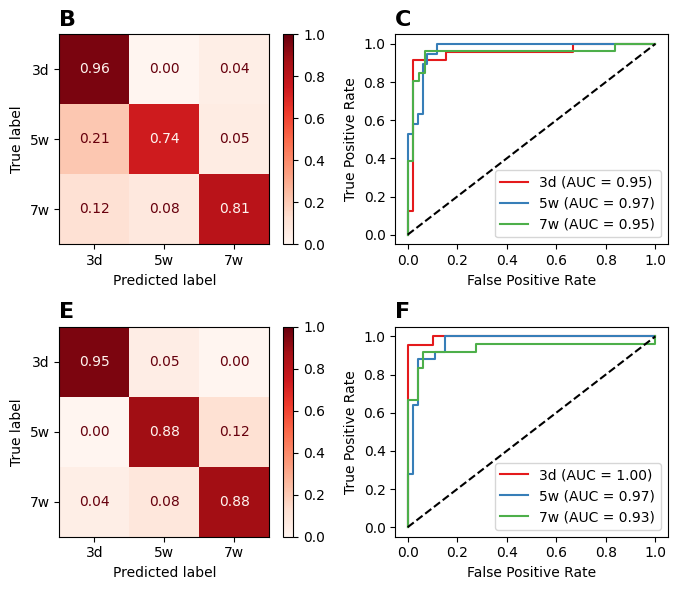

In [38]:
sn.set_palette("Set2")
fig, ((ax2, ax5),(ax4, ax6)) = plt.subplots(2,2,figsize=(7,6))

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})

colors = sn.color_palette("Set1")
#colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_hd_test[:, class_id],
        y_head_prob[:, class_id],
        name=target_names[class_id],
        color=color,
        ax=ax5)
#ax5.get_legend().remove()

ax5.set_xlabel("False Positive Rate")
ax5.set_ylabel("True Positive Rate")

#colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_th_test[:, class_id],
        y_thorax_prob[:, class_id],
        name=target_names[class_id],
        color=color,
        ax=ax6)

ax6.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax5.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

ax6.set_xlabel("False Positive Rate")
ax6.set_ylabel("True Positive Rate")

sizeletters = 16

ax2.set_title("B", loc='left', weight='bold', size=sizeletters)
ax4.set_title("E", loc='left', weight='bold', size=sizeletters)
ax5.set_title("C", loc='left', weight='bold', size=sizeletters)
ax6.set_title("F", loc='left', weight='bold', size=sizeletters)

plt.tight_layout()

#plt.savefig("../results/plots/age_prediction.png", dpi=300)

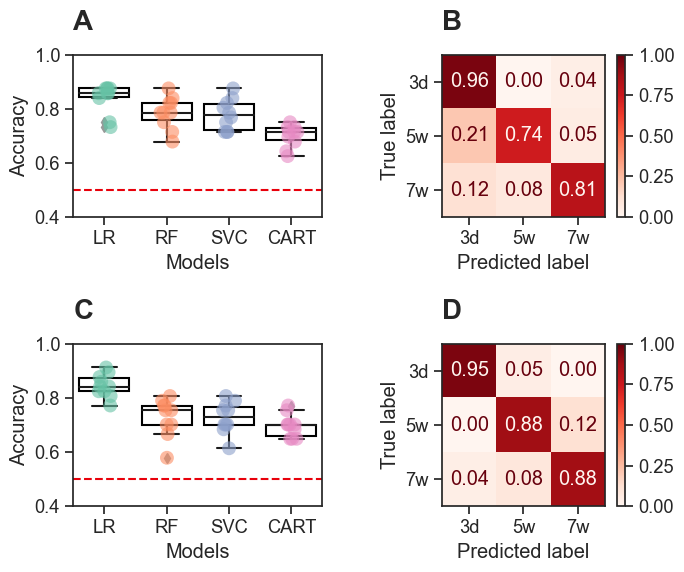

In [135]:
sn.set_palette("Set2")
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,6))

sn.boxplot(data=data_plot_head, x='param_clf', y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value', ax=ax,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax.lines, color='k')
ax.axhline(0.5, color='r',ls='--')
ax.set_ylim(0.4,1)
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")


for i,box in enumerate(ax.patches):
    box.set_edgecolor('black')

sn.boxplot(data=data_plot_thorax, x='param_clf', y='value',ax=ax3, color='white')
sn.stripplot(data=data_plot_thorax, x='param_clf',y='value', ax=ax3,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax3.lines, color='k')
ax3.axhline(0.5, color='r',ls='--')
ax3.set_ylim(0.4,1)
ax3.set_xlabel("Models")
ax3.set_ylabel("Accuracy")
for i,box in enumerate(ax3.patches):
    box.set_edgecolor('black')


disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


ax6.set_xlabel("False Positive Rate")
ax6.set_ylabel("True Positive Rate")

sizeletters = 16

#ax2.set_title("A", loc='left', weight='bold', size=sizeletters)
#ax4.set_title("B", loc='left', weight='bold', size=sizeletters)


labeles = ['A','B','C','D']
axess = [ax, ax2, ax3, ax4]
for k, l in zip(axess, labeles):
    k.set_title(l,y=1.1,weight='bold',loc='left', fontsize=20)

plt.tight_layout()

plt.savefig("../results/plots/informative_region/age_prediction_females.png", dpi=900)


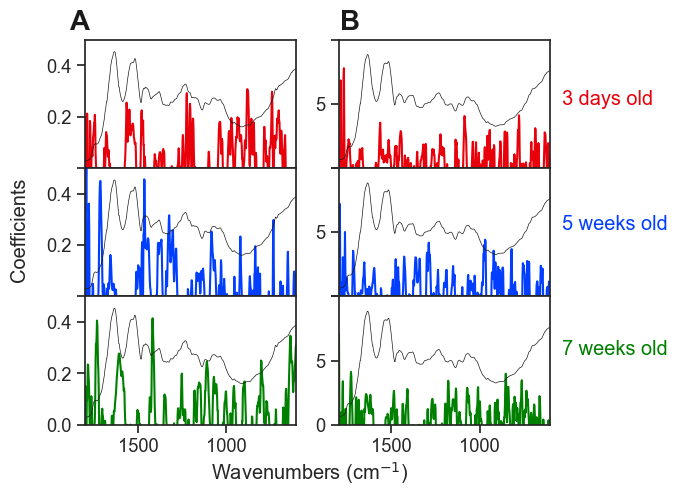

In [189]:
# coefficients

sn.set(font_scale=1.2)
sn.set_palette('bright', color_codes=True)
sn.set_style('ticks')


fig, ((ax,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(6,5),sharex=True, sharey=False)
coef = best_model_head['model'].coef_[0]
sn.lineplot(x=wavenumbers_reduced, y=coef,ax=ax, color='r')
sn.lineplot(x=wavenumbers_reduced, y=best_model_head['model'].coef_[1],ax=ax3,color='b')
sn.lineplot(x=wavenumbers_reduced, y=best_model_head['model'].coef_[2],ax=ax5,color='green')

ax.set_xlim(1800,600)

sn.lineplot(x=wavenumbers_reduced, y=best_mdoel_thorax['model'].coef_[0],ax=ax2, color='r')
sn.lineplot(x=wavenumbers_reduced, y=best_mdoel_thorax['model'].coef_[1],ax=ax4,color='b')
sn.lineplot(x=wavenumbers_reduced, y=best_mdoel_thorax['model'].coef_[2],ax=ax6,color='green')

labeles = ['A','B','C','D']
axes1 = [ax, ax3, ax5]
axes2 = [ax2, ax4, ax6]
for k in axes1:
    k.set_ylim(0,0.5)
    sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_head ,axis=0)*1.5),color='k',ax=k,linewidth=0.5)

for m in axes2:
    m.set_ylim(0,10)
    sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*30),color='k',ax=m,linewidth=0.5)

plt.locator_params(axis='y', nbins=3)

fig.subplots_adjust(hspace=0)

plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.setp(ax.get_yticklabels()[-1], visible=True)

plt.setp(ax2.get_yticklabels()[0], visible=False)    
plt.setp(ax2.get_yticklabels()[-1], visible=False)

plt.setp(ax3.get_yticklabels()[0], visible=False)    
plt.setp(ax3.get_yticklabels()[-1], visible=False)

plt.setp(ax4.get_yticklabels()[0], visible=False)    
plt.setp(ax4.get_yticklabels()[-1], visible=False)

plt.setp(ax5.get_yticklabels()[0], visible=True)    
plt.setp(ax5.get_yticklabels()[-1], visible=False)

plt.setp(ax6.get_yticklabels()[0], visible=True)    
plt.setp(ax6.get_yticklabels()[-1], visible=False)

fig.text(x=0,y=0.5, s='Coefficients', rotation=90, verticalalignment='center')
fig.text(x=0.5,y=0, s='Wavenumbers (cm$^{-1}$)', horizontalalignment='center')


fig.text(x=0.1, y=0.9, s='A', color='k',weight='bold', fontsize=20)
fig.text(x=0.55, y=0.9, s='B', color='k',weight='bold', fontsize=20)

fig.text(x=0.92, y=0.75, s='3 days old', color='r')
fig.text(x=0.92, y=0.5, s='5 weeks old', color='b')
fig.text(x=0.92, y=0.25, s='7 weeks old', color='green')

plt.savefig("../results/plots/informative_region/age_coefficients_females.png", dpi=900,bbox_inches='tight')


Text(0, 0.5, 'Coefficients')

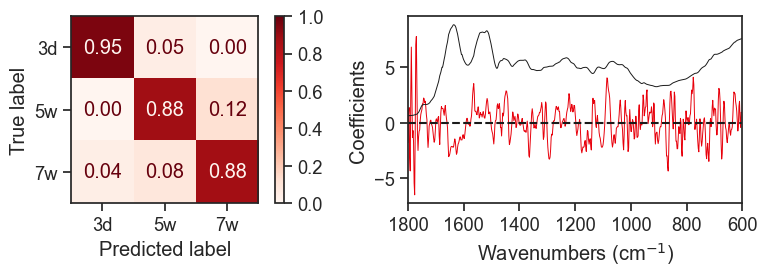

In [85]:
# final plot
# coefficients and confusion matrix for thorax

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=wavenumbers_reduced, y=best_mdoel_thorax['model'].coef_[0],ax=ax2, color='r', linewidth=0.7)
sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*30), ax=ax2, color='k', linewidth=0.7)

ax2.set_xlim(1800,600)
ax2.axhline(0, ls='--', color='k')
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")


#plt.savefig("../results/plots/final_plots/age_prediction_females_thorax.png", dpi=900)



In [98]:
# top wavenumbers

topwavenumbers = variable_importance_df(wavenumbers_reduced,best_mdoel_thorax)
topwavenumbers

,Wavenumbers,Coefficients
15,1770,7.787661
14,1772,7.015233
6,1788,6.834660
512,776,4.116736
357,1086,4.055370
358,1084,4.026268
118,1564,3.542068
16,1768,3.483096
513,774,3.448821
359,1082,3.300049


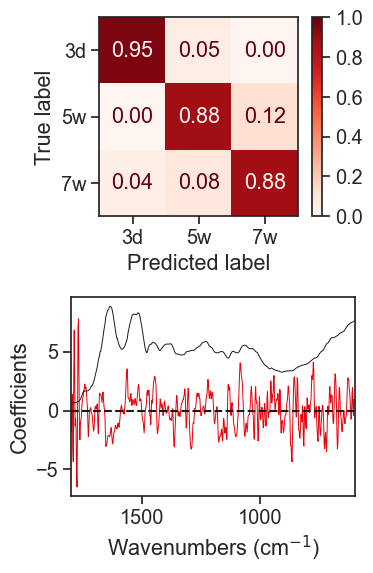

In [135]:
# final plot
# coefficients and confusion matrix for thorax

sn.set(font_scale=1.3)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(2,1, figsize=(4,6), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=wavenumbers_reduced, y=best_mdoel_thorax['model'].coef_[0],ax=ax2, color='r', linewidth=0.7)
sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*30), ax=ax2, color='k', linewidth=0.7)

ax2.set_xlim(1800,600)
ax2.axhline(0, ls='--', color='k')
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")


#for i in range(0, 20):
 #   ax2.axvline(topwavenumbers.iloc[i,0], color='r', alpha=0.5)

plt.savefig("../results/plots/final_plots/age_prediction_females.png", dpi=900)

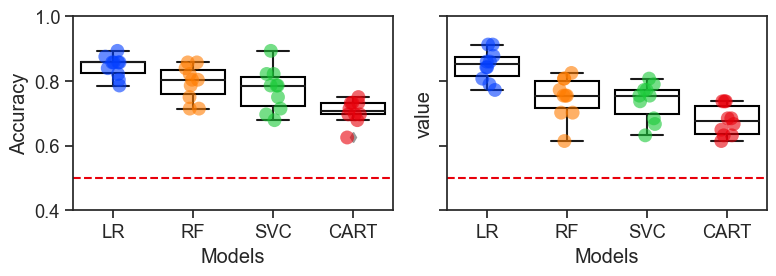

In [65]:
# training plots
# confucion matrix for the head

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax,ax3)) = plt.subplots(1,2, figsize=(8,3), tight_layout=True, sharey=True)

sn.boxplot(data=data_plot_thorax, x='param_clf', y='value',ax=ax3, color='white')
sn.stripplot(data=data_plot_thorax, x='param_clf',y='value', ax=ax3,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax3.lines, color='k')
ax3.axhline(0.5, color='r',ls='--')
ax3.set_ylim(0.4,1)
ax3.set_xlabel("Models")
for i,box in enumerate(ax3.patches):
    box.set_edgecolor('black')

sn.boxplot(data=data_plot_head, x='param_clf', y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value', ax=ax,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax.lines, color='k')
ax.axhline(0.5, color='r',ls='--')
ax.set_ylim(0.4,1)
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
for i,box in enumerate(ax.patches):
    box.set_edgecolor('black')

#plt.savefig("../results/plots/final_plots/age_prediction_females_training_suplementary.png", dpi=900)


Text(0, 0.5, 'Coefficients')

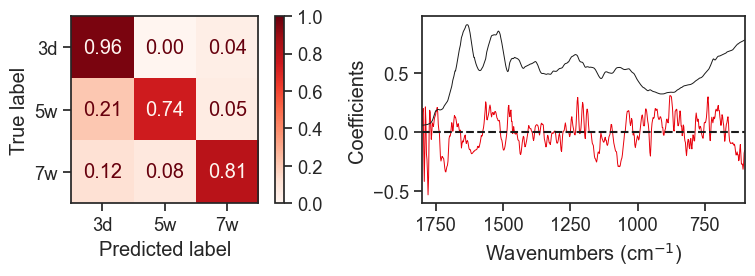

In [117]:
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=wavenumbers_reduced, y=best_model_head['model'].coef_[0],ax=ax2, color='r', linewidth=0.7)
sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_head ,axis=0)*3), ax=ax2, color='k', linewidth=0.7)

ax2.set_xlim(1800,600)
ax2.axhline(0, ls='--', color='k')
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")


#plt.savefig("../results/plots/final_plots/age_prediction_females_head_suplementary.png", dpi=900)
